In [1]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model,layers
import tensorflow as tf
import keras
import torch

import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import os

import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import Callback,EarlyStopping
import tensorflow

Using TensorFlow backend.


In [2]:
path = './data/Train/'
path_all = list(glob.glob(path+'**/*jpg'))
path_Negative = path + 'Intact/*.jpg'
path_Positive = path + 'Crack/*.jpg'

Text(0.5, 1.0, 'Negative and Positive')

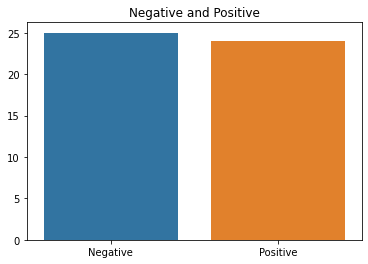

In [3]:
sns.barplot(x=['Negative','Positive'], y=[len(path_Negative), len(path_Positive)])
plt.title('Negative and Positive')

In [4]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_all))
file_Path = pd.Series(path_all, name='File_Path').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([file_Path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Label
0,./data/Train\Crack\08734.jpg,Crack
1,./data/Train\Crack\06733.jpg,Crack
2,./data/Train\Intact\01527.jpg,Intact
3,./data/Train\Intact\16602.jpg,Intact
4,./data/Train\Crack\07823.jpg,Crack


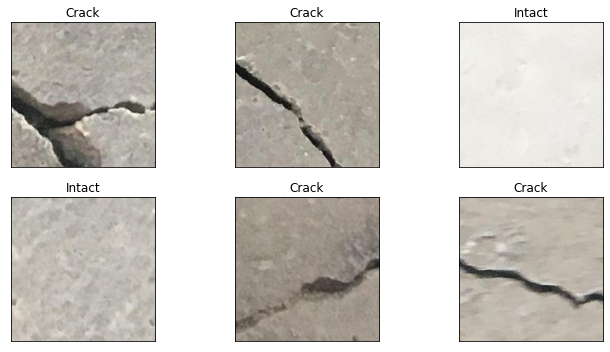

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [6]:
train_df, test_df = train_test_split(data, test_size=0.2)

In [7]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(
                        preprocessing_function=pre,
                        validation_split=0.1)
    test_datagen = ImageDataGenerator(
                        preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(128,128),
        class_mode='categorical',
        batch_size=16,
        shuffle=True
        )
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(128,128),
        class_mode='categorical',
        batch_size=16,
        shuffle=False
    )
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Label',
        target_size=(128,128),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )
    return train_gen, valid_gen, test_gen

In [8]:
def func(name_model):
    pre_model = name_model(input_shape=(128,128, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    outputs = Dense(2, activation='softmax')(pre_model.output)

    model = Model(inputs=inputs, outputs=outputs)
    opt = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss = 'categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=0,
                              mode='auto')]
    return model, my_callbacks

In [9]:
def plot(history,df_test,test_gen,train_gen, model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(df_test.Label,pred)
    clr = classification_report(df_test.Label, pred, target_names=["NEGATIVE", "POSITIVE"])
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df_test.File_Path.iloc[i+1]))
        ax.set_title(f"True: {df_test.Label.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [10]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

In [11]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)

Found 32000 validated image filenames belonging to 2 classes.
Found 32000 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [12]:
MobileNet_model, callback=func(MobileNet)

In [13]:
history_MobileNet = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=10,
    callbacks=callback
)

Epoch 1/10
2000/2000 [==============================] - 53s 26ms/step - loss: 0.0457 - accuracy: 0.9872 - val_loss: 0.0100 - val_accuracy: 0.9975
Epoch 2/10
2000/2000 [==============================] - 53s 27ms/step - loss: 0.0081 - accuracy: 0.9977 - val_loss: 0.0062 - val_accuracy: 0.998225s - loss: 0.0101 - accuracy: 0.99 - ETA: 25s - loss: 0.0095 - accurac - ETA: 25s  - ETA: 1 - ETA: 6s - - ETA: 6s - l - ETA: 2s - loss: 0.0087  - ETA: 
Epoch 3/10
2000/2000 [==============================] - 53s 27ms/step - loss: 0.0057 - accuracy: 0.9983 - val_loss: 0.0047 - val_accuracy: 0.9985 ETA: 19s - loss: 0.0059 - accuracy: 0.9 - ETA: 19s - loss: 0.0060 - accuracy: 0.998 - ETA: 19s - loss: 0.0059 - acc - ETA:  - ETA: 16s - loss: 0.0058 - accuracy: 0.998 - ETA: 16s - loss: 0.0058 - ac - ETA: 0s - loss: 0.0056 - accura - ETA: 0s - loss: 0.0056 - accuracy: 
Epoch 4/10
2000/2000 [==============================] - 54s 27ms/step - loss: 0.0045 - accuracy: 0.9988 - val_loss: 0.0038 - val_accuracy: 

In [14]:
MobileNet_model.save('./saved/Crack_Detection_MobileNet_model.h5')

              precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00      4007
    POSITIVE       1.00      1.00      1.00      3993

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



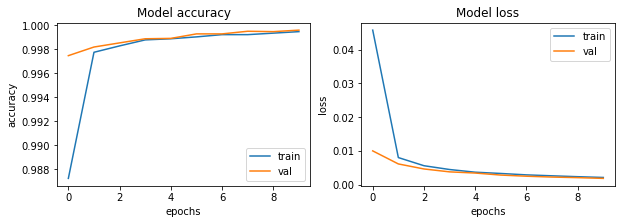

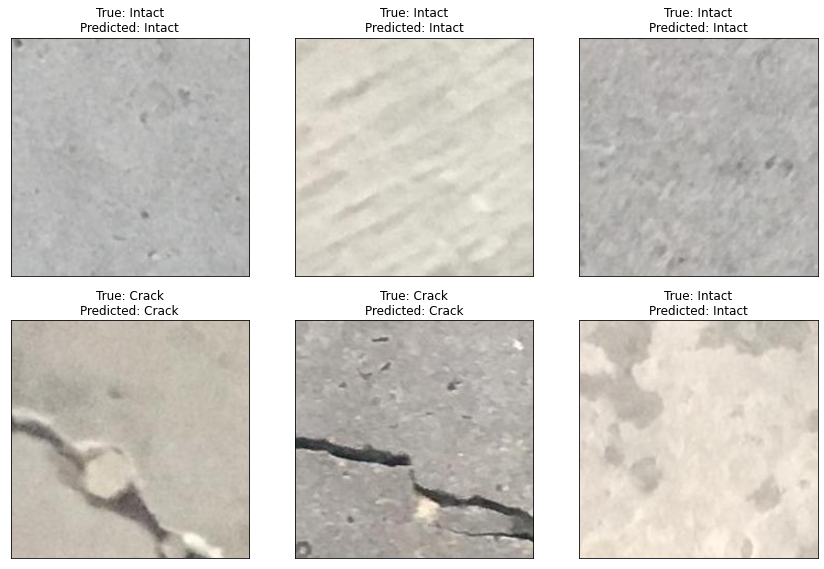

In [15]:
history=plot(history_MobileNet,test_df,test_gen_MobileNet,train_gen_MobileNet, MobileNet_model)

In [16]:
result_MobileNet = result_test(test_gen_MobileNet, MobileNet_model)

    Test Loss: 0.00278
Test Accuracy: 99.91%


In [17]:
output = pd.DataFrame({'Model':['MobileNet'],
                      'Accuracy':[result_MobileNet[1]]})

In [18]:
output

,Model,Accuracy
0,MobileNet,0.999125


In [19]:
import torch

In [20]:
test_images, labels = torch.load('./data/Test/small_1000_set.pth')

In [21]:
MobileNet_model = tensorflow.keras.models.load_model('./saved/Crack_Detection_MobileNet_model.h5')

In [22]:
test_images = test_images.numpy()

In [23]:
test_images.shape

(1000, 3, 227, 227)

In [24]:
images = []
for test_img in test_images:
    images.append(np.moveaxis(test_img, 0, -1))
    
images = np.array(images)

In [25]:
images.shape

(1000, 227, 227, 3)

In [26]:
from PIL import Image 

for i in range(1000):
    path = './data/Test/'
    if labels[i] == 0:
        path += 'Intact/'
    else:
        path += 'Crack/'
    
    img_arr = np.squeeze(images[i])
    _array = img_arr * 255
    _array = _array.astype(np.uint8)
    _image = Image.fromarray(_array)
    _image = _image.save(path + str(i) + '.jpg')

In [27]:
path = './data/Test/'
path_all = list(glob.glob(path+'**/*jpg'))
path_Negative = path + 'Intact/*.jpg'
path_Positive = path + 'Crack/*.jpg'

In [28]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_all))
file_Path = pd.Series(path_all, name='File_Path').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([file_Path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)

In [29]:
from tensorflow.keras.applications.mobilenet import preprocess_input

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=data,
    x_col='File_Path',
    y_col='Label',
    target_size=(128,128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 1000 validated image filenames belonging to 2 classes.


In [30]:
result_MobileNet = result_test(test_gen, MobileNet_model)

    Test Loss: 0.11004
Test Accuracy: 97.60%


In [31]:
MobileNet_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128   